## Import Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,classification_report
from scikitplot.metrics import plot_confusion_matrix

## Load Data

In [2]:
df_train = pd.read_csv("data/train.txt",delimiter=';',names=['text','label'])
df_val = pd.read_csv("data/val.txt",delimiter=';',names=['text','label'])

In [3]:
df = pd.concat([df_train,df_val])
df.reset_index(inplace=True,drop=True)

In [4]:
df.head()

,text,label
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


## EDA

<AxesSubplot: xlabel='label', ylabel='count'>

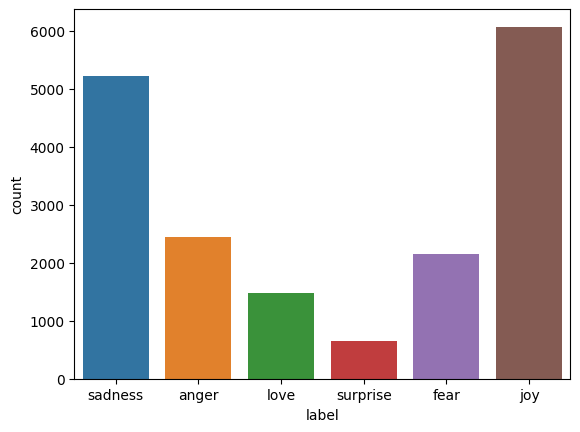

In [5]:
sns.countplot(x = df.label,data= df)

In [6]:
def custom_encoder(df):
    df.replace(to_replace ="surprise", value =1, inplace=True)
    df.replace(to_replace ="love", value =1, inplace=True)
    df.replace(to_replace ="joy", value =1, inplace=True)
    df.replace(to_replace ="fear", value =0, inplace=True)
    df.replace(to_replace ="anger", value =0, inplace=True)
    df.replace(to_replace ="sadness", value =0, inplace=True)

custom_encoder(df.label)

<AxesSubplot: xlabel='label', ylabel='count'>

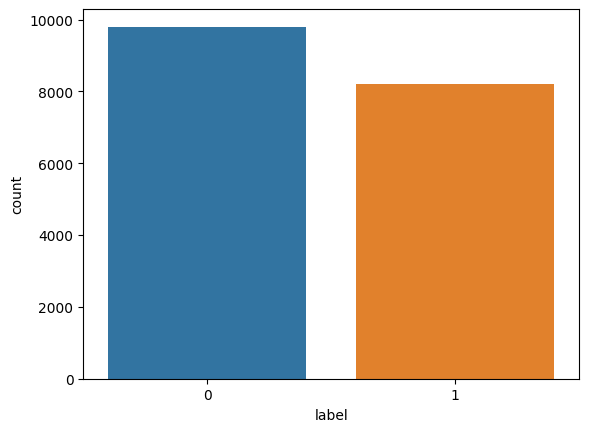

In [7]:
sns.countplot(x = df.label,data= df)

## Pre-Processing

1. First, we will iterate through each record, and using a regular expression, we will get rid of any characters apart from alphabets.

2. Then, we will convert the string to lowercase as, the word `Good` is different from the word `good`.

    Because, without converting to lowercase, it will cause an issue when we will create vectors of these words, as two different vectors will be created for the same word which we don’t want to.

3. Then we will check for stopwords in the data and get rid of them. Stopwords are commonly used words in a sentence such as `the`, `an`, `to` etc. which do not add much value.

4. Then, we will perform `lemmatization` on each word,i.e. change the different forms of a word into a single item called a `lemma`.

A lemma is a base form of a word. For example, `run`, `running` and `runs` are all forms of the same lexeme, where the `run` is the lemma. Hence, we are converting all occurrences of the same lexeme to their respective lemma.

5. And, then return a corpus of processed data.

In [8]:
lm = WordNetLemmatizer()

In [9]:
def text_transformation(df_col):
    corpus = []
    for item in df_col:
        new_item = re.sub('[^a-zA-Z]',' ',str(item))
        new_item = new_item.lower()
        new_item = new_item.split()
        new_item = [lm.lemmatize(word) for word in new_item if word not in set(stopwords.words('english'))]
        corpus.append(' '.join(str(x) for x in new_item))
    return corpus

corpus = text_transformation(df.text)

## Word Cloud

 **Word Cloud** It is a data visualization technique used to depict text in such a way that, the more frequent words appear enlarged as compared to less frequent words. This gives us a little insight into, how the data looks after being processed through all the steps until now.

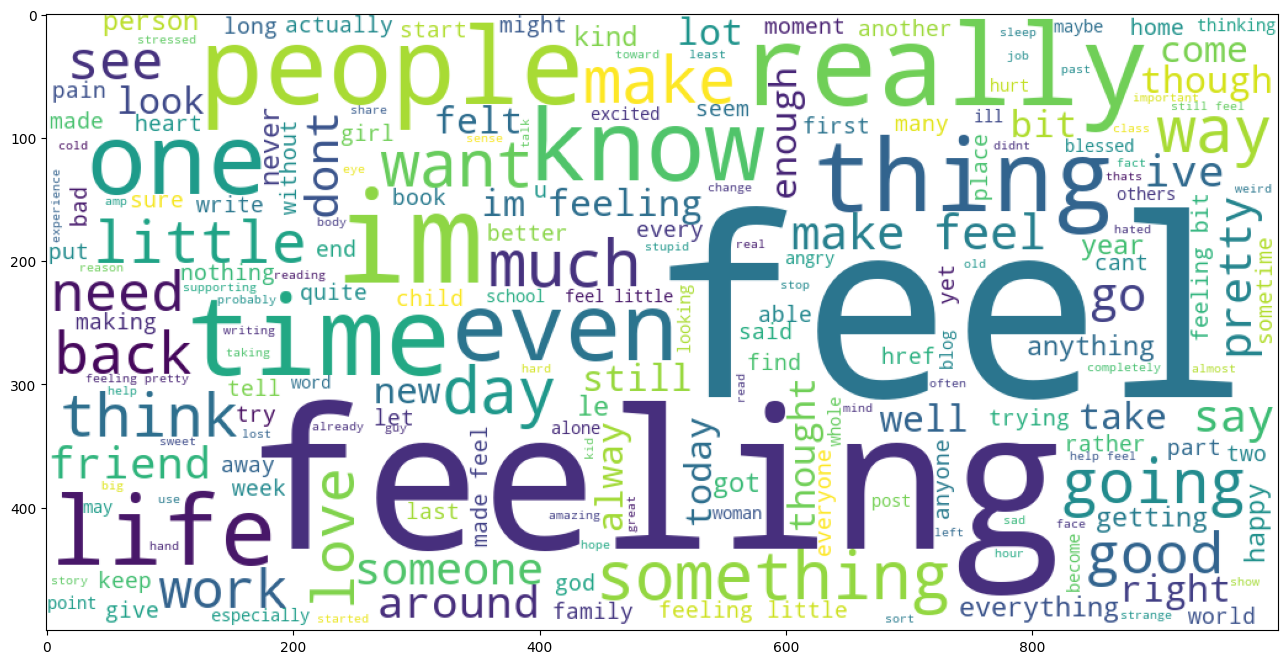

In [10]:
from matplotlib import rcParams

rcParams['figure.figsize'] = 20,8
word_cloud = ""
for row in corpus:
    for word in row:
        word_cloud+=" ".join(word)
wordcloud = WordCloud(width = 1000, height = 500,background_color ='white',min_font_size = 10).generate(word_cloud)
plt.imshow(wordcloud)

## Bag of Words

 **Bag of Words Model(BOW)**, which is used to represent the text in the form of a bag of words,i.e. the grammar and the order of words in a sentence are not given any importance, instead, multiplicity,i.e. (the number of times a word occurs in a document) is the main point of concern.

In [11]:
cv = CountVectorizer(ngram_range=(1,2))
traindata = cv.fit_transform(corpus)
X = traindata
y = df.label

SVC Classifier

In [12]:
from sklearn.svm import SVC

svc = SVC(C=1, gamma=0.1, kernel='rbf', probability=True)
svc.fit(X,y)

SVC(C=1, gamma=0.1, probability=True)

In [ ]:
# defining parameter range
param_grid = {'C': [1, 10, 100],
              'gamma': [1, 0.1, 0.01],
              'kernel': ['rbf','poly']}
 
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3)
 
# fitting the model for grid search
grid.fit(X,y)

Test Data

In [14]:
test_df = pd.read_csv('data/test.txt',delimiter=';',names=['text','label'])

In [15]:
X_test,y_test = test_df.text,test_df.label
#encode the labels into two classes , 0 and 1
test_df = custom_encoder(y_test)
#pre-processing of text
test_corpus = text_transformation(X_test)
#convert text data into vectors
testdata = cv.transform(test_corpus)
#predict the target
predictions = svc.predict(testdata)

Model Evaluation

We will evaluate our model using various metrics such as Accuracy Score, Precision Score, Recall Score, Confusion Matrix and create a roc curve to visualize how our model performed.

Accuracy_score:  0.9535
Precision_score:  0.9661781285231116
Recall_score:  0.9315217391304348
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.94      0.97      0.96      1080
           1       0.97      0.93      0.95       920

    accuracy                           0.95      2000
   macro avg       0.95      0.95      0.95      2000
weighted avg       0.95      0.95      0.95      2000



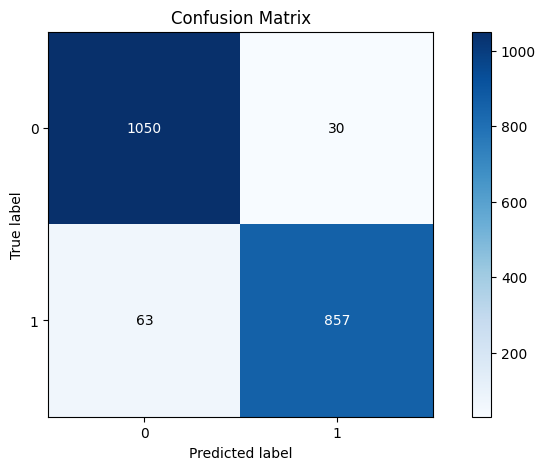

In [16]:
rcParams['figure.figsize'] = 10,5
plot_confusion_matrix(y_test,predictions)
acc_score = accuracy_score(y_test,predictions)
pre_score = precision_score(y_test,predictions)
rec_score = recall_score(y_test,predictions)
print('Accuracy_score: ',acc_score)
print('Precision_score: ',pre_score)
print('Recall_score: ',rec_score)
print("-"*50)
cr = classification_report(y_test,predictions)
print(cr)

Roc Curve

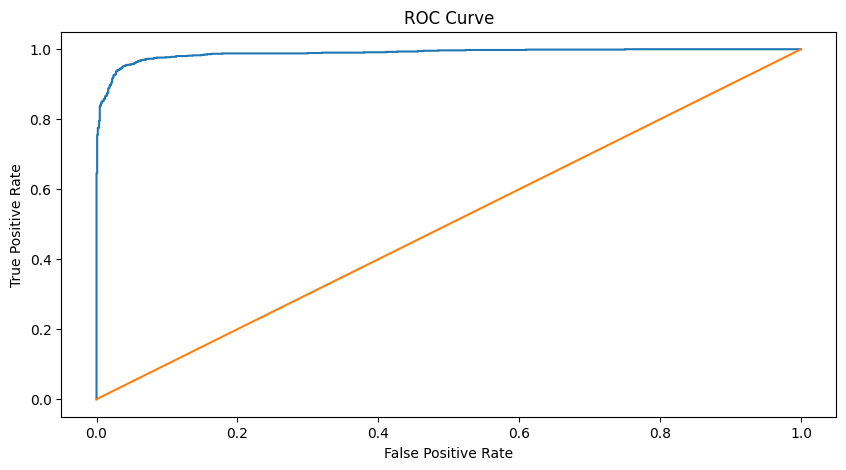

In [17]:
predictions_probability = svc.predict_proba(testdata)
fpr,tpr,thresholds = roc_curve(y_test,predictions_probability[:,1])
plt.plot(fpr,tpr)
plt.plot([0,1])
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

Predict for Custom Input

In [18]:
def expression_check(prediction_input):
    if prediction_input == 0:
        print("Input statement has Negative Sentiment.")
    elif prediction_input == 1:
        print("Input statement has Positive Sentiment.")
    else:
        print("Invalid Statement.")

In [19]:
def sentiment_predictor(input):
    input = text_transformation(input)
    transformed_input = cv.transform(input)
    prediction = svc.predict(transformed_input)
    expression_check(prediction)

In [26]:
input1 = ["Get out from here"]
input2 = ["I bought a new phone and it's so good."]

In [27]:
sentiment_predictor(input1)
sentiment_predictor(input2)

Input statement has Negative Sentiment.
Input statement has Positive Sentiment.
